In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

### Choose a file from a scan or...

In [2]:
fc = FileChooser('/sf/alvra/data/p19506/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileChooser(path='/sf/alvra/data/p19506/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [17]:
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

filenumber = 15
data = scan[filenumber]
print (data.fnames[0])
print (Energy_eV[filenumber])

/sf/alvra/data/p19506/raw/scan_data/018_XAS_ZnAce/run_000713.BSDATA.h5
9660.11580154847


### ... Choose a file not in a scan

In [9]:
#data = SFDataFiles('/sf/alvra/data/p18442/raw/RuFoil_3keV_mono/run_000163.*')
data = SFDataFiles('/sf/alvra/data/p18938/raw/check_izero_intensity/run_034524*')
print (data.fnames[0])

/sf/alvra/data/p18938/raw/check_izero_intensity/run_034524.BSDATA.h5


### PIPS diode and Izero

In [18]:
channel_list = [channel_APD_Ch1, channel_APD_Ch2, channel_Izero117, channel_APD_waveform_1, channel_APD_waveform_2]
                
########################################################################################################
data = scan[filenumber]
print (data)
results, _ = load_data_compact(channel_list, data)
data.close()

IzeroFEL = results[channel_Izero117]

APD1 = -results[channel_APD_Ch1]
APD2 = -results[channel_APD_Ch2]

APD1_wf = results[channel_APD_waveform_1]
APD2_wf = results[channel_APD_waveform_2]



SFDataFiles("/sf/alvra/data/p19506/raw/scan_data/018_XAS_ZnAce/run_000713.BSDATA.h5", "/sf/alvra/data/p19506/raw/scan_data/018_XAS_ZnAce/run_000713.CAMERAS.h5"): 383 channels

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_BUFFER   1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_BUFFER   1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  1002 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 1000 / 1002 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1002 -> 0% loss
complete channels: 5 / 6 -> 17% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


In [113]:
Bad_wf = APD1_wf.copy()

In [82]:
np.shape(APD1_wf[0:1000])
np.shape(np.mean(APD1_wf[0:1], axis = 0))

(2000,)

<IPython.core.display.Javascript object>


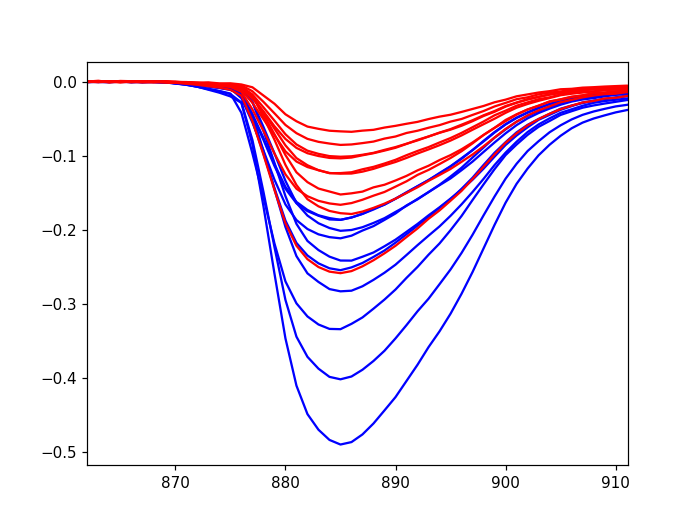

In [120]:
plt.figure()
plt.plot(APD1_wf[:10].T, color = 'b')
plt.plot(Bad_wf[:10].T, color = 'r')
#plt.plot(np.mean(APD1_wf[0:1], axis = 0))
#plt.plot(np.mean(APD1_wf[1001:-1], axis = 0))
#plt.plot(np.mean(APD1_wf, axis = 0))
#plt.plot(APD1)
plt.ylim(-0.6,0.05)
plt.xlim(800, 1000)
plt.show()

Energy = 9660.11580154847 eV
Median value Izero (all) = 0.9092603231130107
Median value fluo (all) = 3.3527426654182354e-06
correlation = 0.001967371047827169


<IPython.core.display.Javascript object>


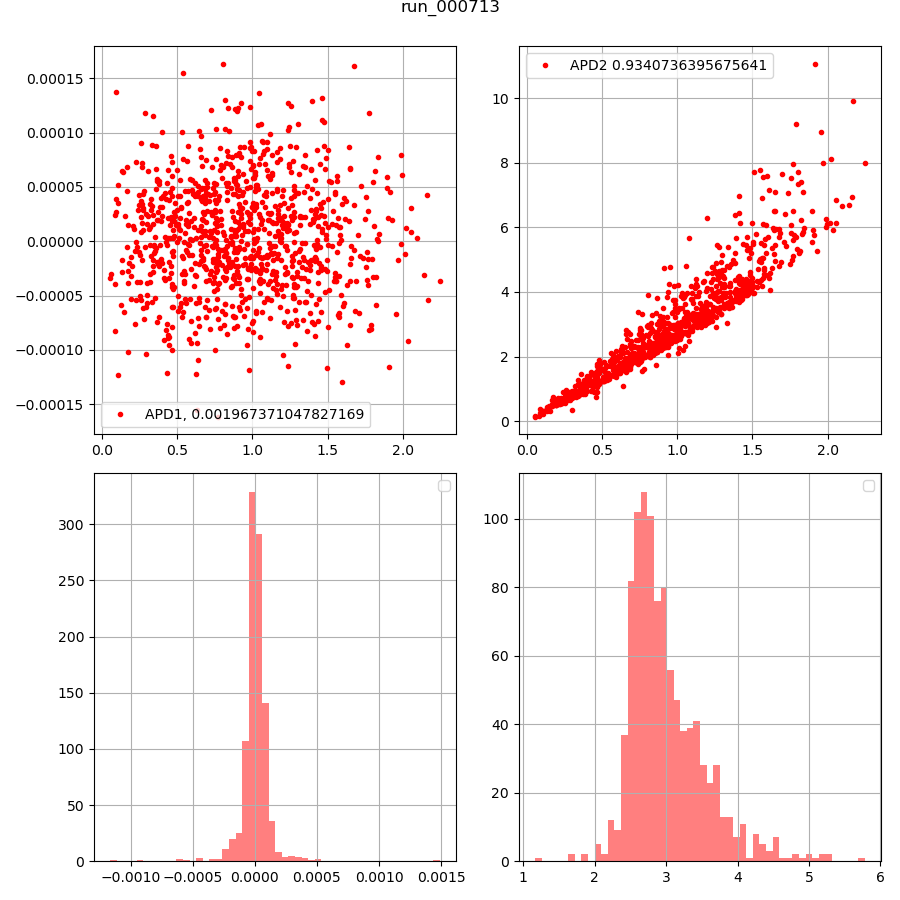

No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-19-72b4cc9742b5>:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


In [19]:
print ("Energy = {} eV".format(Energy_eV[filenumber]))
print ("Median value Izero (all) = {}".format(np.median(IzeroFEL)))
print ("Median value fluo (all) = {}".format(np.median(APD1)))
print ("correlation = {}".format(pearsonr(IzeroFEL,APD1)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,9))
plt.suptitle(data.fnames[0].split('/')[-1].split('.')[0], y = 1)

plt.subplot(221)
plt.plot(IzeroFEL, APD1, color = 'red',  linestyle='None', label='APD1, {}'.format(pearsonr(IzeroFEL,APD1)[0]),marker='.')
plt.grid()
#plt.xlim(0,2)
plt.legend(loc="best")

plt.subplot(222)
plt.plot(IzeroFEL, APD2, color = 'red',  linestyle='None', label='APD2 {}'.format(pearsonr(IzeroFEL,APD2)[0]),marker='.')
plt.grid()
#plt.xlim(0,2)
plt.legend(loc="best")

plt.subplot(223)
plt.hist(APD1/IzeroFEL, bins=  50, facecolor='red', label='', alpha=0.5)
plt.grid()
#plt.xlim(0,2)
plt.legend(loc="best")

plt.subplot(224)
plt.hist(APD2/IzeroFEL, bins = 50, facecolor='red', label='', alpha=0.5)
plt.grid()
#plt.xlim(0,2)
plt.legend(loc="best")

plt.tight_layout()


In [44]:
cond = (APD1 < 12) & (IzeroFEL < 1.2)
APD1_good = APD1[cond == 1]
print (np.shape(APD1_good))
print (np.shape(APD1_good)[0]/np.shape(APD1)[0])

(558,)
0.5682281059063137


Energy = 7122.951326527921 eV
Median value Izero (all) = 0.1065090736374259
Median value fluo (all) = 0.2745361328125
correlation = 0.9790664644972118


<IPython.core.display.Javascript object>


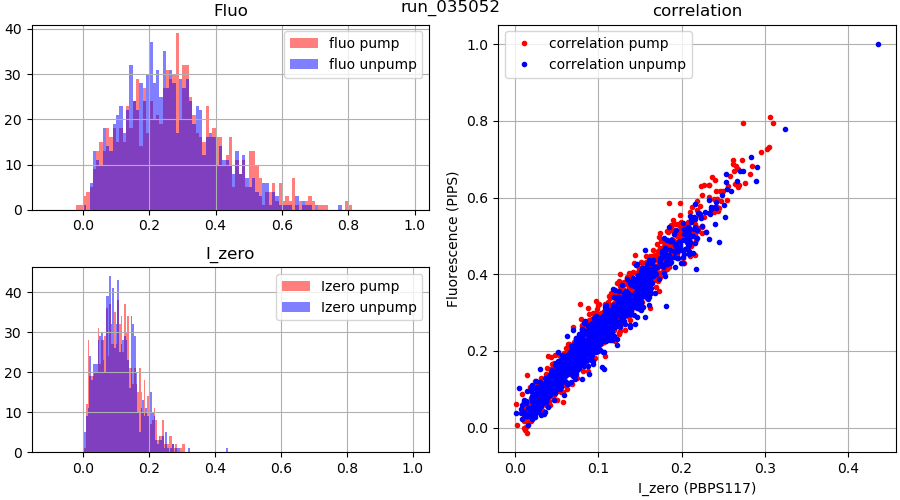

In [81]:
print ("Energy = {} eV".format(Energy_eV[filenumber]))
print ("Median value Izero (all) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (all) = {}".format(np.median(DataFluo_pump_shot)))
print ("correlation = {}".format(pearsonr(IzeroFEL_pump_shot,DataFluo_pump_shot)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(data.fnames[0].split('/')[-1].split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.1,1,0.01), facecolor='red', label="fluo pump", alpha=0.5)
plt.hist(DataFluo_unpump_shot, bins =np.arange(-0.1,1,0.01), facecolor='blue', label="fluo unpump", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_pump_shot, bins =np.arange(-0.1,1,0.005), facecolor='red', label='Izero pump', alpha=0.5)
plt.hist(IzeroFEL_unpump_shot, bins =np.arange(-0.1,1,0.005), facecolor='blue', label='Izero unpump', alpha=0.5)

plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_pump_shot, DataFluo_pump_shot, color = 'red',  linestyle='None', label='correlation pump',marker='.')
plt.plot(IzeroFEL_unpump_shot, DataFluo_unpump_shot, color = 'blue',  linestyle='None', label='correlation unpump',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS117)")
plt.ylabel ("Fluorescence (PIPS)")

plt.show()

## JF and Izero

In [31]:
channel_list = [channel_Izero117, channel_Izero122, channel_energy, 'JF04T01V01','JF10T01V01']

########################################################################################################

print (data)
results = load_data_compact(channel_list, data)
data.close()

Energy_shot   = results[channel_energy]
IzeroFEL117_shot = results[channel_Izero117]
IzeroFEL122_shot = results[channel_Izero122]
DataFluoJFimage_shot = results ['JF04T01V01']

SFDataFiles("/sf/alvra/data/p18741/raw/Co_YIG_monoscan_Fe_001/run_001705.BSDATA.h5", "/sf/alvra/data/p18741/raw/Co_YIG_monoscan_Fe_001/run_001705.BSREAD.h5", "/sf/alvra/data/p18741/raw/Co_YIG_monoscan_Fe_001/run_001705.JF04T01V01.h5", "/sf/alvra/data/p18741/raw/Co_YIG_monoscan_Fe_001/run_001705.JF10T01V01.h5"): 82 channels

--------------------------------------------------------------------------------

JF04T01V01                        2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF10T01V01                        2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet           2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY         1932 / 2000 -> 3% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 2000 / 2000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1932 / 2000 -> 3% loss
complete channels: 5 / 6 -> 17% incomplete

--------------------------------------------------------------------------------

FEL rep ra

Energy = 7127.022226110858 eV
Median value Izero (all) = 0.3117787428200245
Median value fluo (all) = 1.0422046184539795
correlation = 0.9957028746199222


<IPython.core.display.Javascript object>


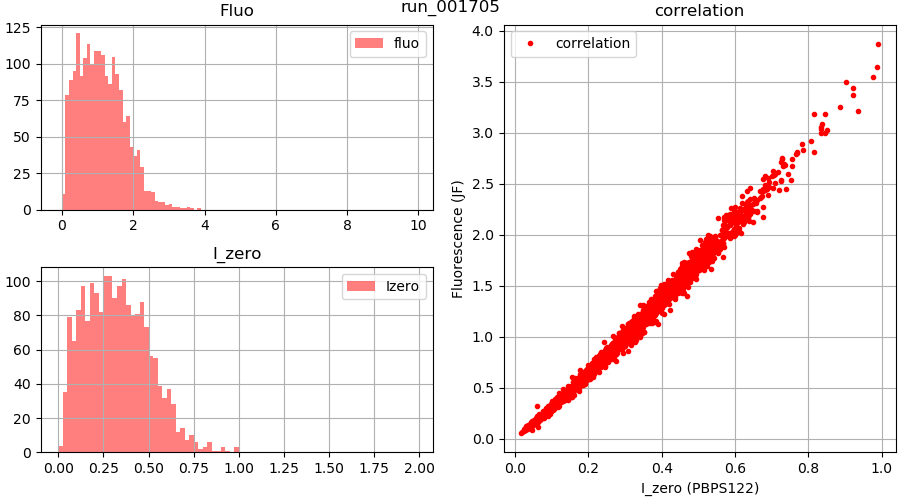

In [44]:
threshold_low = 5.5
threshold_high = 10

pid_roll = 0

nframes = DataFluoJFimage_shot.shape[0]
DataFluoJFimage_shot_thr = DataFluoJFimage_shot.copy()

for j in range(nframes):
    image = DataFluoJFimage_shot[j,:]
    image_thr = DataFluoJFimage_shot[j,:].copy()
    image_thr[image < threshold_low] = 0
    #image_thr[image > threshold_high] = 0
    DataFluoJFimage_shot_thr[j,:] = image_thr.copy()

IzeroFEL_shot = IzeroFEL122_shot.copy()

DataFluoJF_shot = np.roll(DataFluoJFimage_shot_thr.mean(axis = 1).mean(axis = 1), pid_roll, axis = 0)
DataFluoJF_shot_raw = DataFluoJF_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(IzeroFEL_shot)))
print ("Median value fluo (all) = {}".format(np.median(DataFluoJF_shot_raw)))
print ("correlation = {}".format(pearsonr(IzeroFEL_shot,DataFluoJF_shot)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(data.fnames[0].split('/')[-1].split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluoJF_shot, bins =np.arange(-0.1,10,0.1), facecolor='red', label="fluo", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_shot, bins =np.arange(0,2,0.025), facecolor='red', label='Izero', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_shot, DataFluoJF_shot, color = 'red',  linestyle='None', label='correlation',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (JF)")

plt.show()

## JF with itself

0


<IPython.core.display.Javascript object>


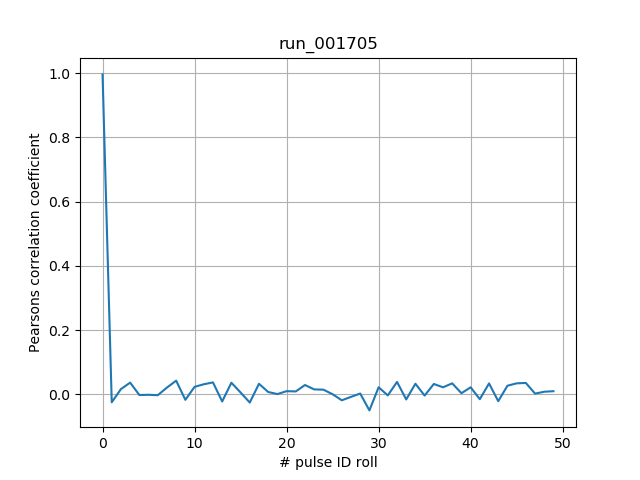

In [43]:
from scipy.stats.stats import pearsonr

DataFluoJF_shot_rot = np.copy(DataFluoJF_shot)
corr = []

for i in range (50):
    DataFluoJF_shot_rot = np.roll(DataFluoJF_shot, i, axis = 0)
    corr.append(pearsonr(IzeroFEL_shot,DataFluoJF_shot_rot)[0])
corr = np.asarray(corr)
print (np.argmax(corr))

plt.figure()
plt.title(data.fnames[0].split('/')[-1].split('.')[0])
plt.plot(corr)
plt.ylabel('Pearsons correlation coefficient')
plt.xlabel('# pulse ID roll')
plt.grid()
plt.show()

## Izero vs Izero

Energy = 7127.022226110858 eV
Median value Izero 117 (all) = 1.034642018377781
Median value Izero 122 (all) = 0.3117787428200245
correlation = 0.997936014780009


<IPython.core.display.Javascript object>


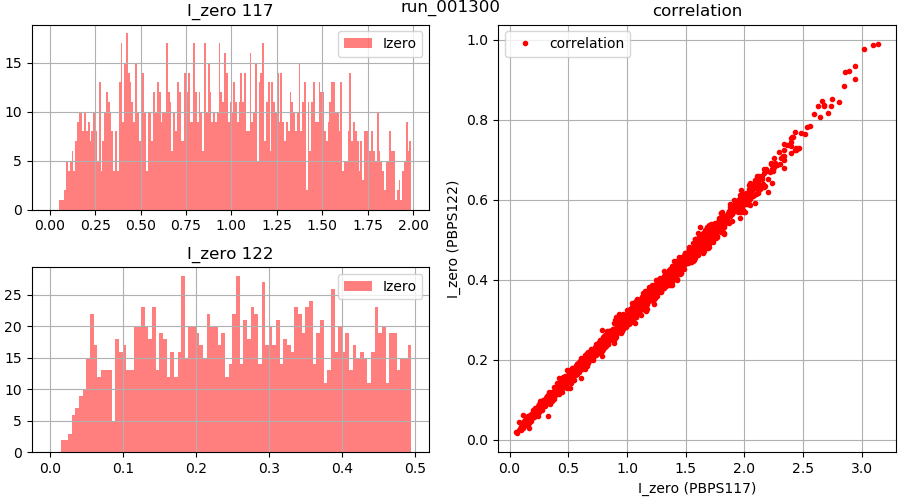

In [48]:
IzeroFEL_shot1 = IzeroFEL117_shot.copy()
IzeroFEL_shot2 = IzeroFEL122_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero 117 (all) = {}".format(np.median(IzeroFEL_shot1)))
print ("Median value Izero 122 (all) = {}".format(np.median(IzeroFEL_shot2)))
print ("correlation = {}".format(pearsonr(IzeroFEL_shot1,IzeroFEL_shot2)[0]))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(data.fnames[0].split('/')[-1].split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('I_zero 117')
plt.hist(IzeroFEL_shot1, bins =np.arange(0,2,0.01), facecolor='red', label="Izero", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero 122')
plt.hist(IzeroFEL_shot2, bins =np.arange(0,0.5,0.005), facecolor='red', label='Izero', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_shot1, IzeroFEL_shot2, color = 'red',  linestyle='None', label='correlation',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS117)")
plt.ylabel ("I_zero (PBPS122)")

plt.show()

In [5]:
scan_name ="Co_YIG_monoscan_008"
DIR_json = "/sf/alvra/data/p18741/raw/scan_info/"
DIR = "/sf/alvra/data/p18741/raw/" + scan_name + "/"             #use this for a scan

#######################################################################

!ls -lah -rt $DIR | grep h5
!hostname

-rw-r--r--.  1 root p18741 4.9G Dec  9 00:08 run_000890.JF04T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:08 run_000890.JF10T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:09 run_000891.JF10T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:09 run_000891.JF04T01V01.h5
-rw-r--r--.  1 root p18741 603M Dec  9 00:10 run_000890.BSREAD.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:10 run_000892.JF04T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:10 run_000892.JF10T01V01.h5
-rw-r--r--.  1 root p18741  58M Dec  9 00:11 run_000890.BSDATA.h5
-rw-r--r--.  1 root p18741 603M Dec  9 00:11 run_000891.BSREAD.h5
-rw-r--r--.  1 root p18741  22M Dec  9 00:11 run_000891.BSDATA.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:11 run_000893.JF10T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:11 run_000893.JF04T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:12 run_000894.JF04T01V01.h5
-rw-r--r--.  1 root p18741 4.9G Dec  9 00:12 run_000894.JF10T01V01.h5
-rw-r--r--.  1 root p18741 603M Dec 

ra-c-004.psi.ch


In [10]:
f ="run_000893*.h5"
fn = DIR + f

channel_list_pp = [channel_Events, channel_Izero117, channel_Izero122,'JF04T01V01','JF10T01V01']
channel_list_all = channel_list_pp + [channel_energy]

resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, fn)

Energy_shot   = results[channel_energy]

IzeroFEL117_pump_shot = resultsPP[channel_Izero122].pump
IzeroFEL117_unpump_shot = resultsPP[channel_Izero122].unpump
DataFluoJFimage_pump_shot = resultsPP ['JF04T01V01']
DataFluoJFimage_unpump_shot = resultsPP ['JF04T01V01']

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF04T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000886.JF04T01V01.res.h5
jungfrau file: 00:11 09.12.2020
pedestal file: 22:55 08.12.2020
    mtime difference: 1:16:11.631875
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF10T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000886.JF10T01V01.res.h5
jungfrau file: 00:11 09.12.2020
pedestal file: 22:55 08.12.2020
    mtime difference: 1:16:06.969933
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF04T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000886.JF04T01V01.res.h5
jungfrau file: 00:11 09.12.2020
pedestal file: 22:55 08.12.2020
    mtime difference: 1:16:11.631875
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF10T01V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18741/raw/JF_pedestals/run_000886.JF10T01V01.res.

## Pump probe JF and Izero

In [8]:
threshold_low = 5
threshold_high = 10

pid_roll = 0

nframes = DataFluoJFimage_pump_shot.shape[0]
DataFluoJFimage_pump_shot_thr = DataFluoJFimage_pump_shot.copy()
DataFluoJFimage_unpump_shot_thr = DataFluoJFimage_unpump_shot.copy()

for j in range(nframes):
    image_pump = DataFluoJFimage_pump_shot[j,:]
    image_unpump = DataFluoJFimage_unpump_shot[j,:]
    
    image_pump_thr = DataFluoJFimage_pump_shot[j,:].copy()
    image_unpump_thr = DataFluoJFimage_unpump_shot[j,:].copy()
    
    image_pump_thr[image_pump < threshold_low] = 0
    image_unpump_thr[image_unpump < threshold_low] = 0
    
    #image_pump_thr[image_pump > threshold_high] = 0
    #image_unpump_thr[image_unpump > threshold_high] = 0
    
    DataFluoJFimage_pump_shot_thr[j,:] = image_pump_thr.copy()
    DataFluoJFimage_unpump_shot_thr[j,:] = image_unpump_thr.copy()
    

IzeroFEL_pump_raw = IzeroFEL117_pump_shot.copy()

DataFluo_pump_shot = np.roll(DataFluoJFimage_pump_shot_thr.mean(axis = 1).mean(axis = 1), pid_roll, axis = 0)
DataFluo_unpump_shot = np.roll(DataFluoJFimage_unpump_shot_thr.mean(axis = 1).mean(axis = 1), pid_roll, axis = 0)
DataFluoJF_shot_raw = DataFluoJF_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(np.concatenate((IzeroFEL_pump_raw, IzeroFEL_unpump_raw), axis=0))))
print ("Median value fluo (all) = {}".format(np.median(np.concatenate((DataFluo_pump_shot_raw, DataFluo_unpump_shot_raw), axis=0))))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="pump", alpha=0.5)
plt.hist(DataFluo_unpump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='grey', label="unpump", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label='pump', alpha=0.5)
plt.hist(IzeroFEL_unpump_shot, bins =np.arange(0,0.85,0.01), facecolor='blue', label ='unpump', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_pump_shot, DataFluo_pump_shot, color = 'red',  linestyle='None', label='pump',marker='.')
plt.plot(IzeroFEL_unpump_shot, DataFluo_unpump_shot, color = 'blue',  linestyle='None', label='unpump',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")

plt.show()

AttributeError: 'PPData' object has no attribute 'shape'